# RESUMO

# IMPORTANDO BIBLIOTECAS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm
import math
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
import warnings
warnings.filterwarnings('ignore')

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

tqdm.pandas()


c:\Users\VitorAquino\anaconda3\envs\renner\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# CARREGANDO DADOS

In [3]:
df_train = pd.read_csv('dados/train.csv')
df_test = pd.read_csv('dados/test.csv')
df_submission = pd.read_csv('dados/sample_submission.csv')

# EDA

## Sumário das colunas

In [4]:
# summary table function
def summary(df):
    print(f'data shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values 
    summ['%missing'] = df.isnull().sum().values / len(df)* 100
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    
    return summ

In [5]:
summary(df_train)

data shape: (15289, 18)


,data type,#missing,%missing,#unique,min,max
id,int64,0,0.0,15289,0.000000,15288.000000
clonesize,float64,0,0.0,6,10.000000,40.000000
honeybee,float64,0,0.0,7,0.000000,18.430000
bumbles,float64,0,0.0,11,0.000000,0.585000
andrena,float64,0,0.0,16,0.000000,0.750000
osmia,float64,0,0.0,14,0.000000,0.750000
MaxOfUpperTRange,float64,0,0.0,6,69.700000,94.600000
MinOfUpperTRange,float64,0,0.0,5,39.000000,57.200000
AverageOfUpperTRange,float64,0,0.0,5,58.200000,79.000000
MaxOfLowerTRange,float64,0,0.0,6,50.200000,68.200000


In [6]:
summary(df_test)

data shape: (10194, 17)


,data type,#missing,%missing,#unique,min,max
id,int64,0,0.0,10194,15289.000000,25482.000000
clonesize,float64,0,0.0,5,10.000000,37.500000
honeybee,float64,0,0.0,7,0.000000,18.430000
bumbles,float64,0,0.0,8,0.000000,0.585000
andrena,float64,0,0.0,12,0.000000,0.750000
osmia,float64,0,0.0,14,0.000000,0.750000
MaxOfUpperTRange,float64,0,0.0,7,69.700000,94.600000
MinOfUpperTRange,float64,0,0.0,6,39.000000,57.200000
AverageOfUpperTRange,float64,0,0.0,6,58.200000,79.000000
MaxOfLowerTRange,float64,0,0.0,5,50.200000,68.200000


* Não temos dados faltantes para esse dataset

## Distribuição da variável target

In [7]:
# select numerical and categorical variables respectively.
num_cols = df_test.select_dtypes(include=['float64','int64']).columns.tolist()
num_cols.remove('id')

<Figure size 2000x800 with 0 Axes>

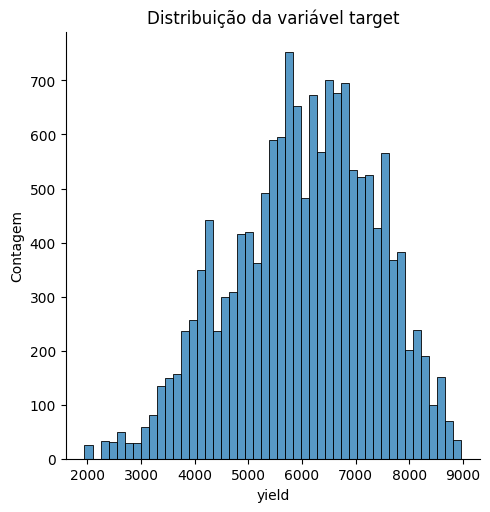

In [8]:
plt.figure(figsize=(20,8))
sns.displot(df_train, x="yield")
plt.title('Distribuição da variável target')
plt.ylabel('Contagem')
plt.show()

**A variável target apresenta uma distrubuição próxima a normal**

In [9]:
df_train['yield'].kurtosis()

-0.436563864726061

* Como a Kurtosis é um pouco inferior a 0, temos que a nossa distribuição é um pouco mais achatada que a distribuição normal

In [10]:
df_train['yield'].skew()

-0.29119496049488897

* Como a Skewness da curva está dentro do intervalo de -0.5 e 0.5, podemos considerar a curva como uma curva normal.

## Comparação da distribuição das variáveis do treino e do teste

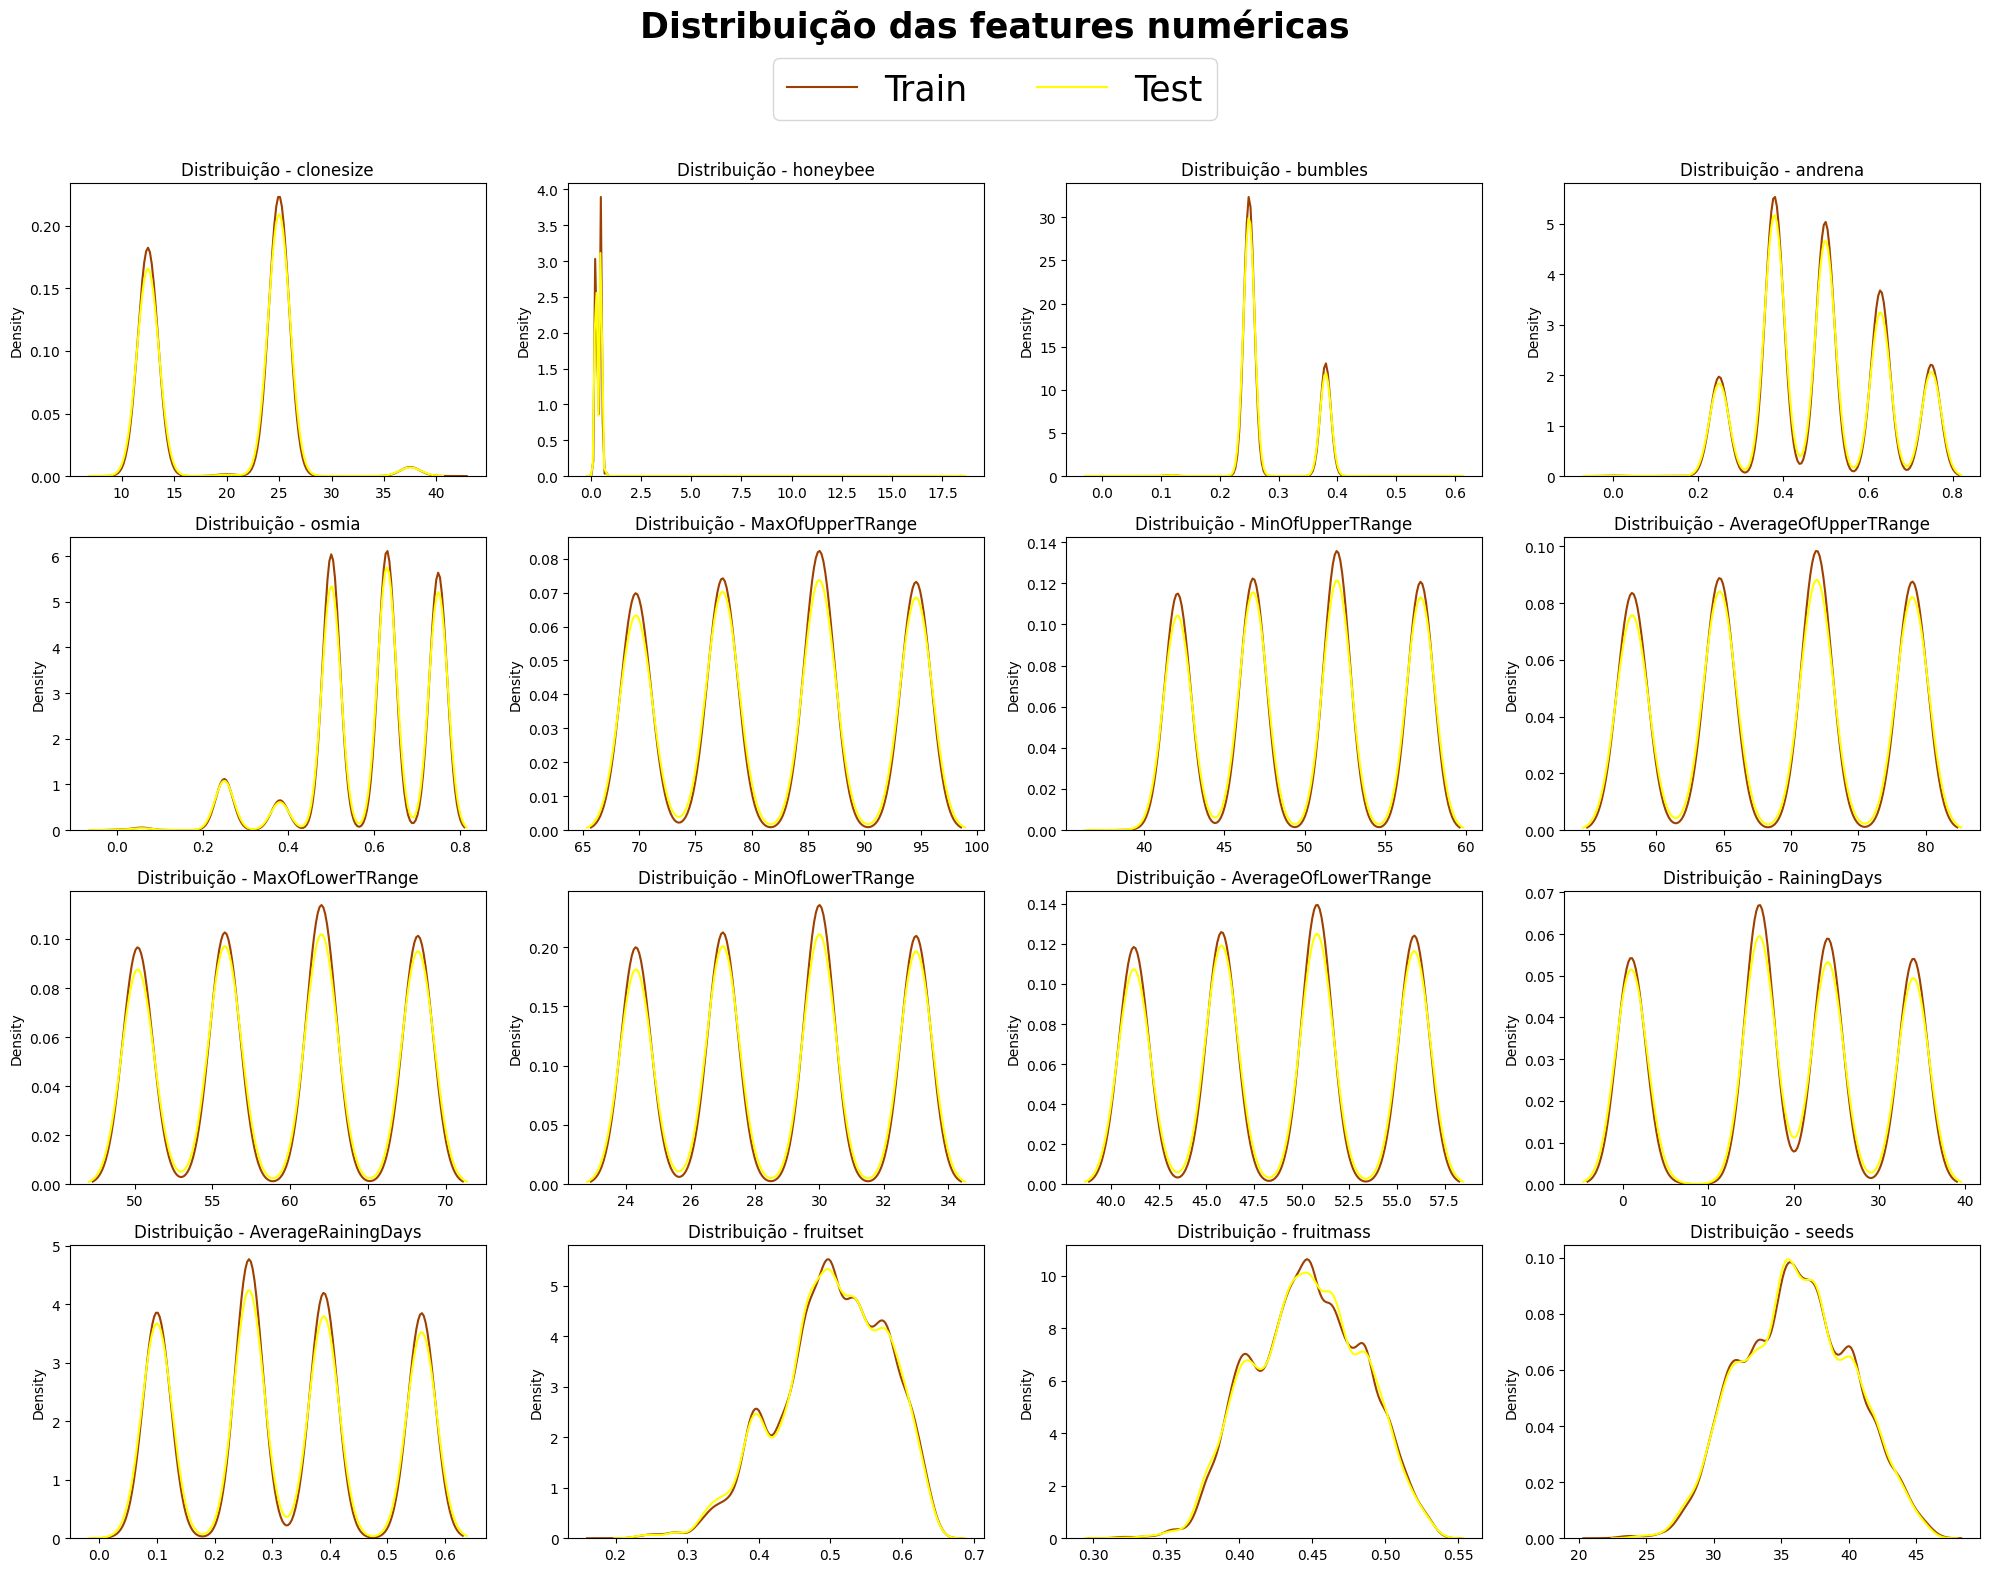

In [11]:
features = num_cols
n_bins = 50
histplot_hyperparams = {
    'kde':True,
    'alpha':0.4,
    'stat':'percent',
    'bins':n_bins
}

columns = features
n_cols = 4
n_rows = math.ceil(len(columns)/n_cols)
fig, ax = plt.subplots(n_rows, n_cols, figsize=(20, n_rows*4))
ax = ax.flatten()

for i, column in enumerate(columns):
    plot_axes = [ax[i]]
    sns.kdeplot(
        df_train[column], label='Train',
        ax=ax[i], color='#9E3F00'
    )
    
    sns.kdeplot(
        df_test[column], label='Test',
        ax=ax[i], color='yellow'
    )
    

    # titles
    ax[i].set_title(f'Distribuição - {column}');
    ax[i].set_xlabel(None)
    
    # remove axes to show only one at the end
    plot_axes = [ax[i]]
    handles = []
    labels = []
    for plot_ax in plot_axes:
        handles += plot_ax.get_legend_handles_labels()[0]
        labels += plot_ax.get_legend_handles_labels()[1]
        plot_ax.legend().remove()
    
for i in range(i+1, len(ax)):
    ax[i].axis('off')
    
fig.suptitle(f'Distribuição das features numéricas\n\n\n', ha='center',  fontweight='bold', fontsize=25)
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.96), fontsize=25, ncol=3)
plt.tight_layout()

* A distribuição do teste é muito similar a distribuição do treino para todas as variáveis
* É necessário fazer um scaling das variáveis para utilizar um modelo

## Correlação das variáveis

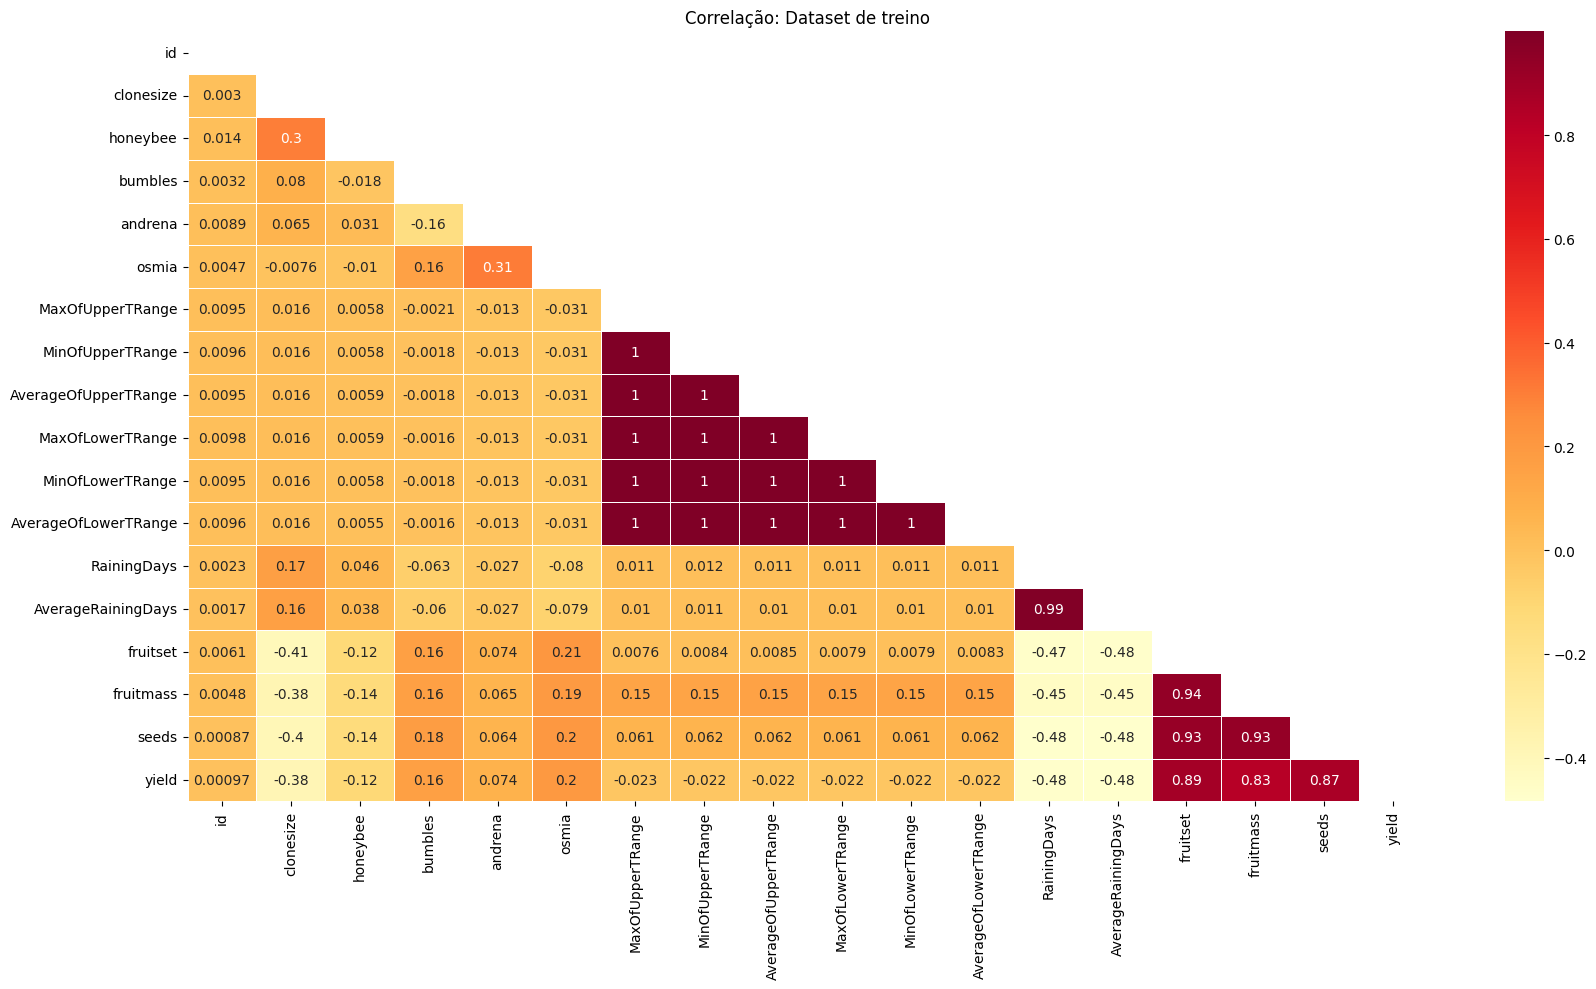

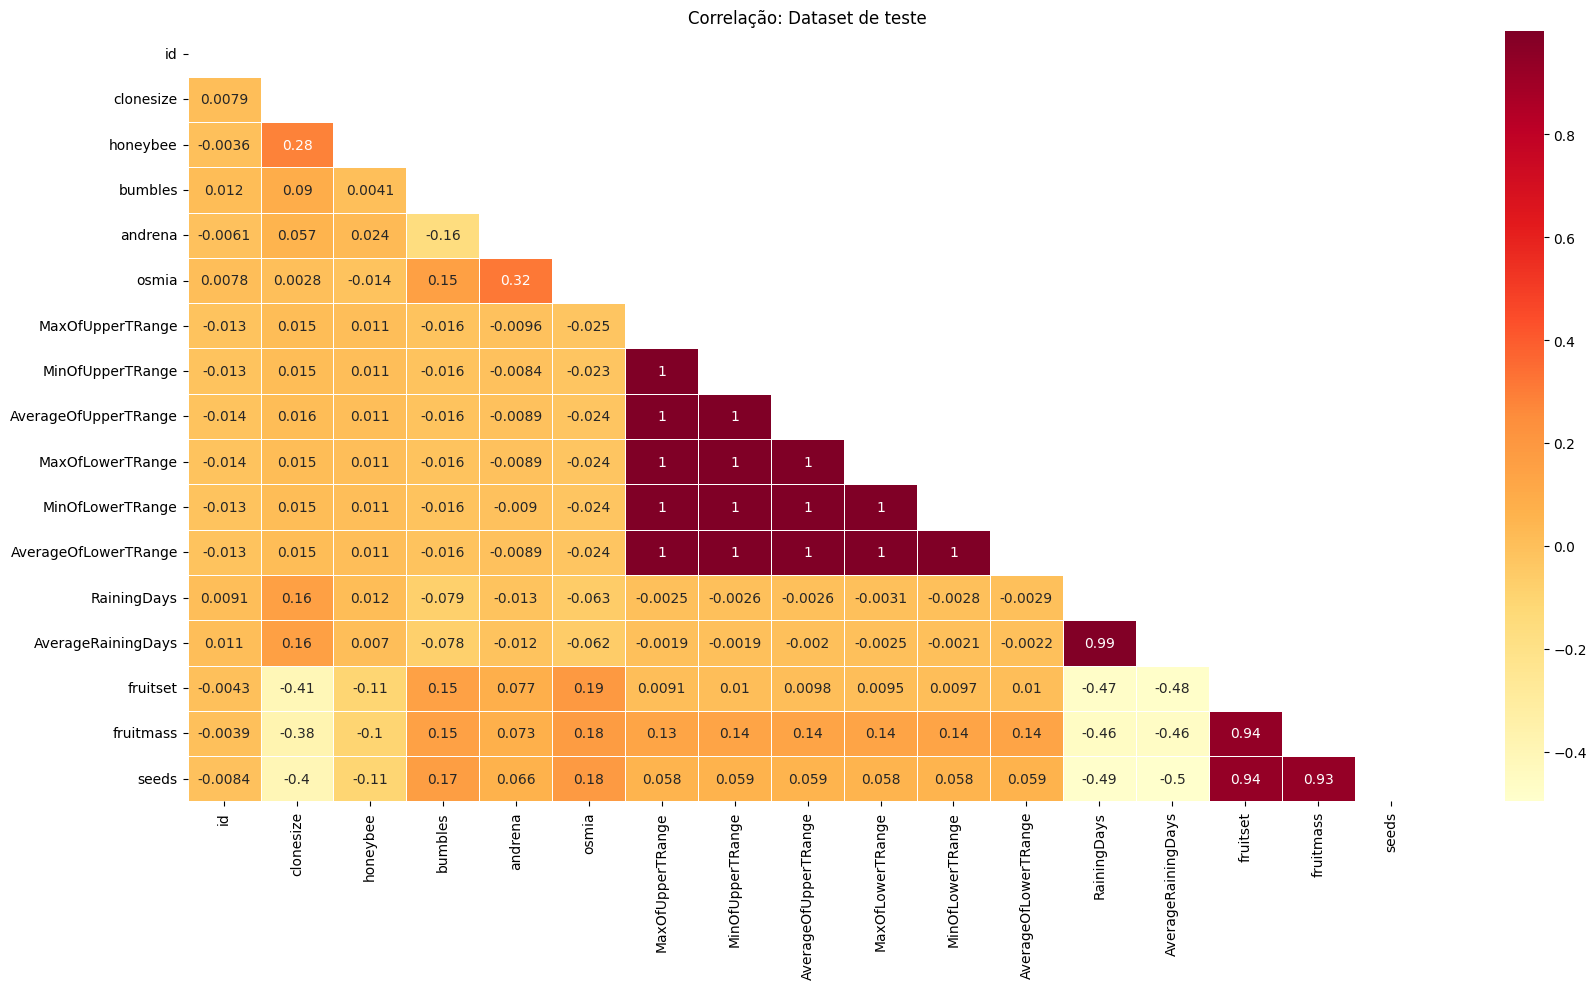

In [12]:
def plot_correlation_heatmap(df: pd.core.frame.DataFrame, title_name: str='Train correlation') -> None:
    corr = df.corr()
    fig, axes = plt.subplots(figsize=(20, 10))
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr, mask=mask, linewidths=.5, cmap='YlOrRd', annot=True)
    plt.title(title_name)
    plt.show()

# plot_correlation_heatmap(original, 'Original Dataset Correlation')
plot_correlation_heatmap(df_train, 'Correlação: Dataset de treino')
plot_correlation_heatmap(df_test, 'Correlação: Dataset de teste')


> **Comparação com a variável target**
    >>* As variáveis com maior correlação a variável 'yield': 'seeds', 'fruitmass', 'fruitset', 'AverageRainingDays', 'RainingDays', 'clonesize'  
    >>* Temos que fazer uma análise de quais variáveis vão entrar no modelo, já que temos variáveis altamente correlacionadas entre si

## Análise bivariada das features mais correlacionadas com a variável target

In [13]:
subset_pairplot = df_train[['clonesize', 'RainingDays', 'AverageRainingDays', 'fruitset', 'fruitmass', 'seeds', 'yield']]

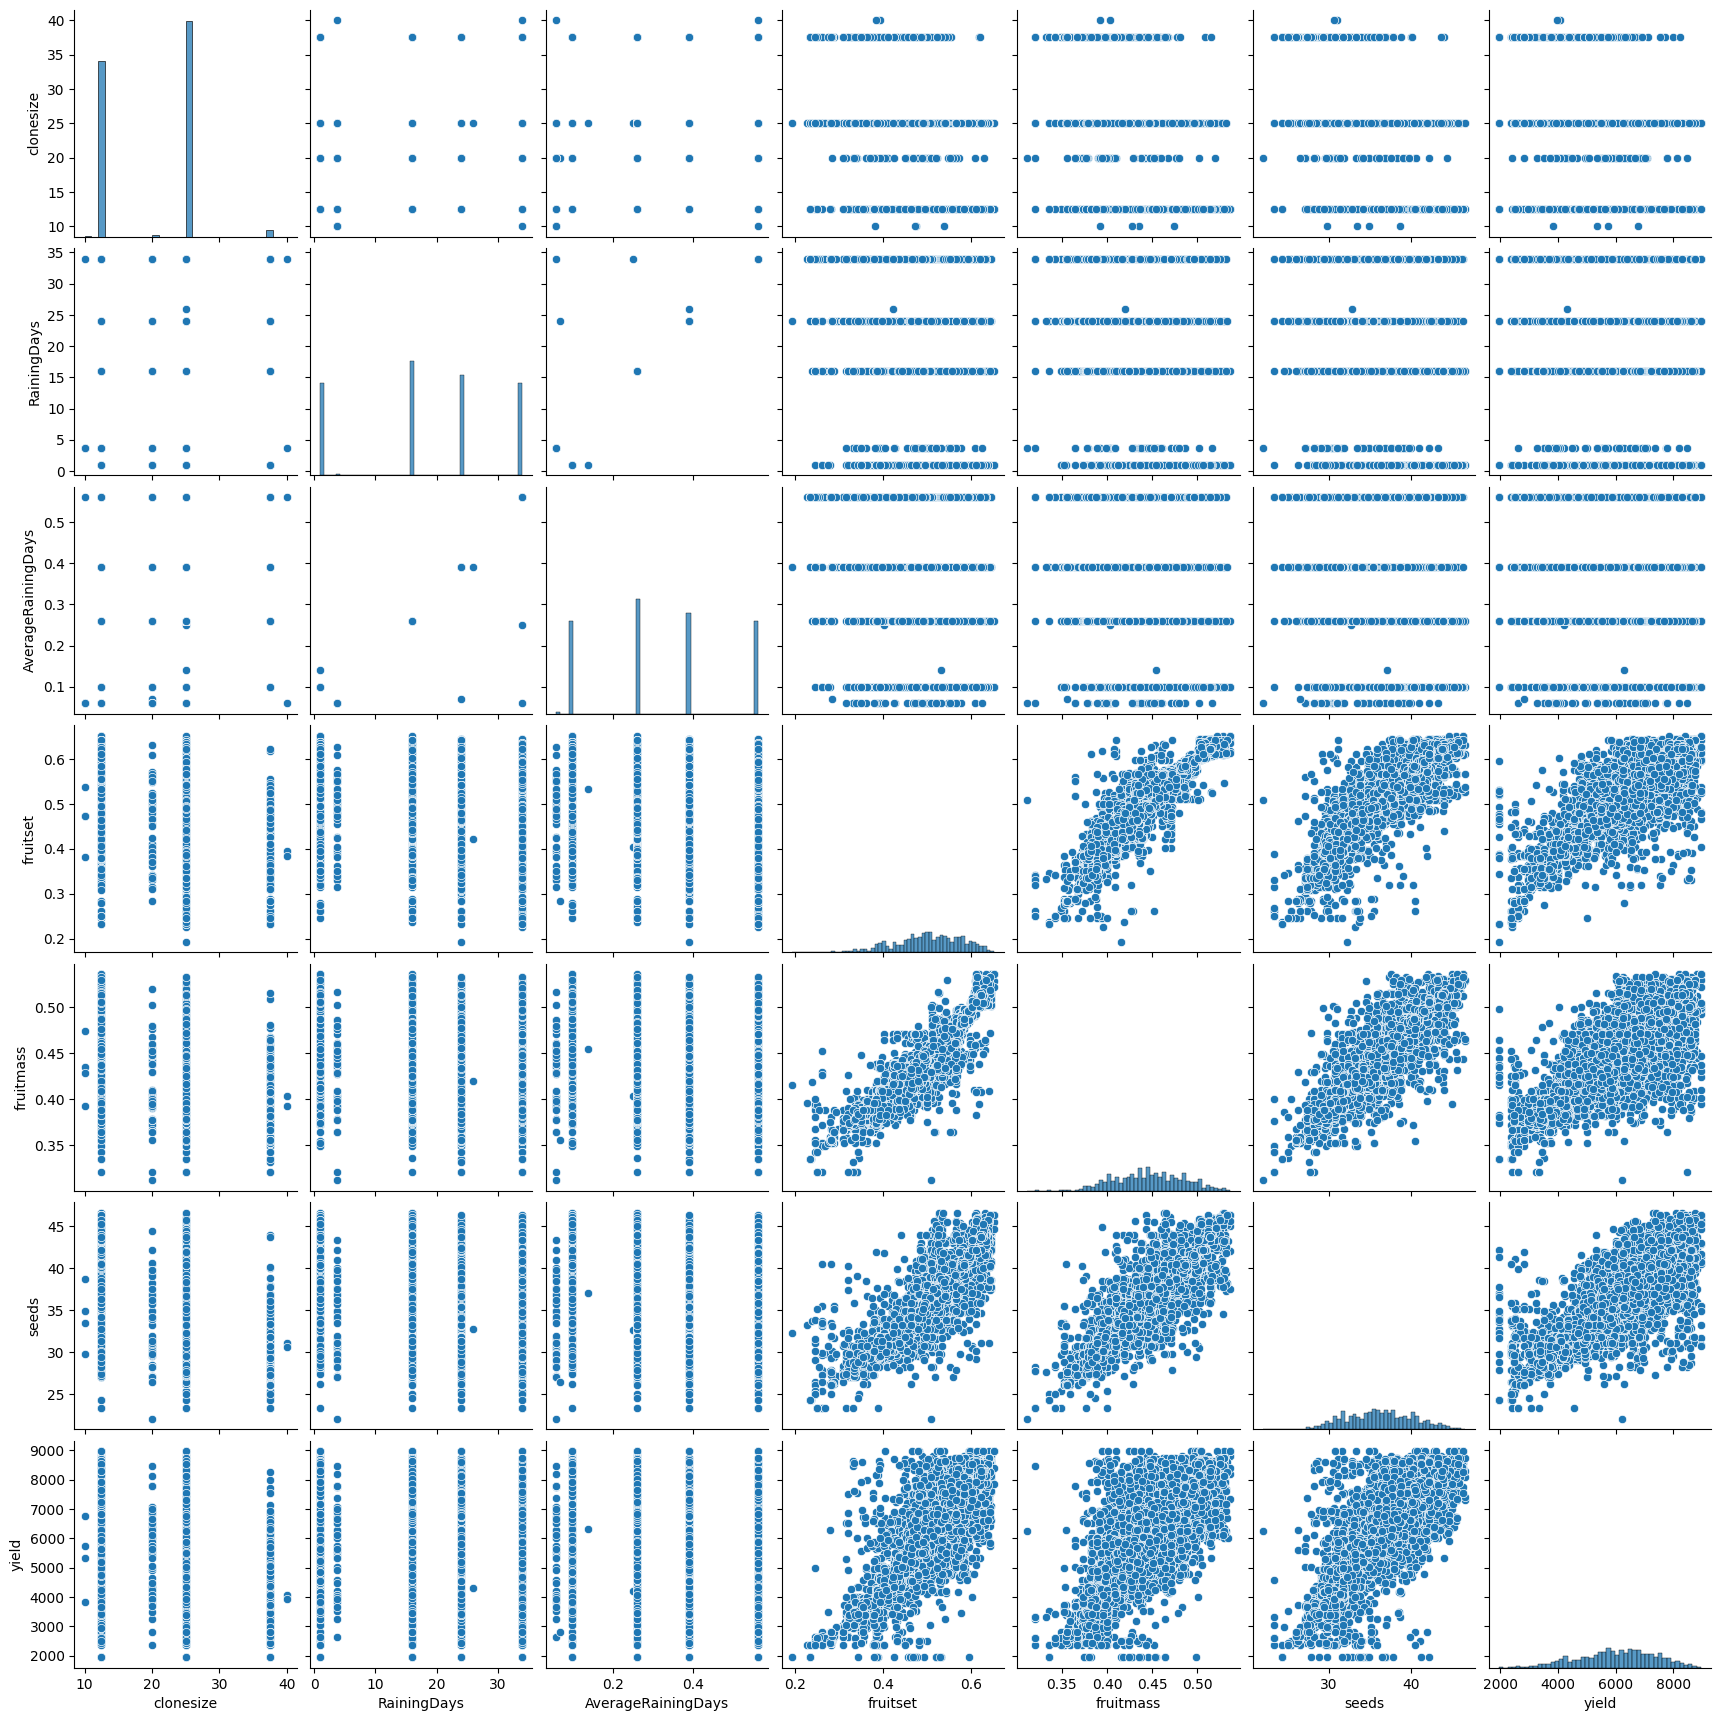

In [14]:
sns.pairplot(subset_pairplot)
plt.show()

Avaliando a distribuição, não é possível identificar uma correlação muito alta entre as variavéis 'clonesize', 'RainingDays' e 'AverageRainingDays' com a variável target.

# MODELOS

In [15]:

from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso

In [16]:
lista_modelo_utilizado = []
lista_num_features = []
lista_MAE = []

## OLS

In [17]:
def teste_de_modelo_OLS(X, y, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=10)
    MAE_scores = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        OLS = LinearRegression()
        OLS = OLS.fit(X_train, y_train)
        y_pred = OLS.predict(X_test).squeeze().tolist()

        MAE = mean_absolute_error(y_true=y_test, y_pred=y_pred)
        MAE_scores.append(MAE)


    # Exibir a média e o desvio padrão dos scores de MAE
    print(f'Média dos scores de MAE: {np.mean(MAE_scores)}')
    print(f'Desvio padrão dos scores de MAE: {np.std(MAE_scores)}')

    # Coeficientes do modelo (feature importance) e nomes das features
    feature_importance = OLS.coef_[0]
    feature_names = X.columns  # Substitua pelos nomes reais das suas features

    # Criar um DataFrame para facilitar a plotagem
    df_importance = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

    # Plotar a importância dos recursos
    plt.figure(figsize=(8, 6))
    sns.barplot(x='Importance', y='Feature', data=df_importance, orient='h')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance')
    plt.show()

    return np.mean(MAE_scores), len(feature_names)

### TODAS AS FEATURES

Média dos scores de MAE: 376.17378276148435
Desvio padrão dos scores de MAE: 14.56552749259025


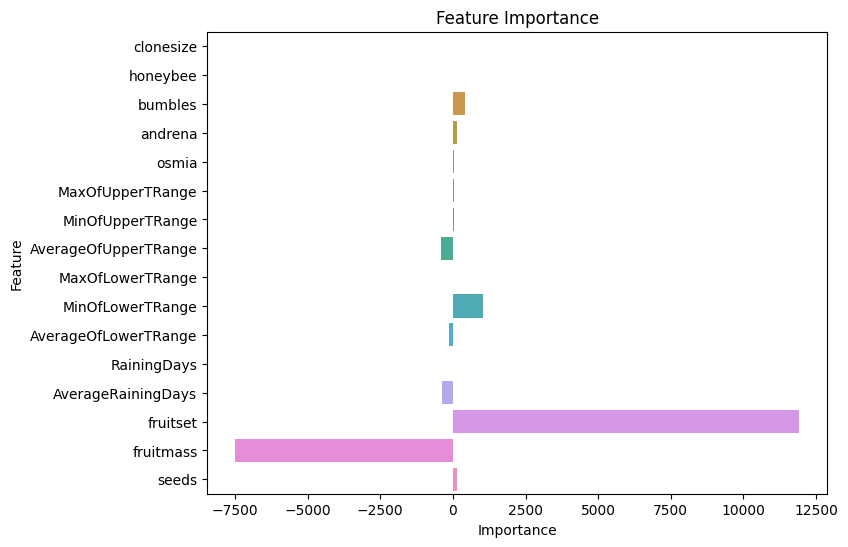

In [18]:
X = df_train.drop(columns=['id', 'yield'], axis=1)
y = df_train[['yield']]

MAE_modelo, num_features  = teste_de_modelo_OLS(X, y)

lista_modelo_utilizado.append('OLS')
lista_num_features.append(num_features)
lista_MAE.append(MAE_modelo)

### SOMENTE FEATURES CORRELACIONADAS COM VARIÁVEL TARGET

Média dos scores de MAE: 372.57083033800353
Desvio padrão dos scores de MAE: 5.584087307749434


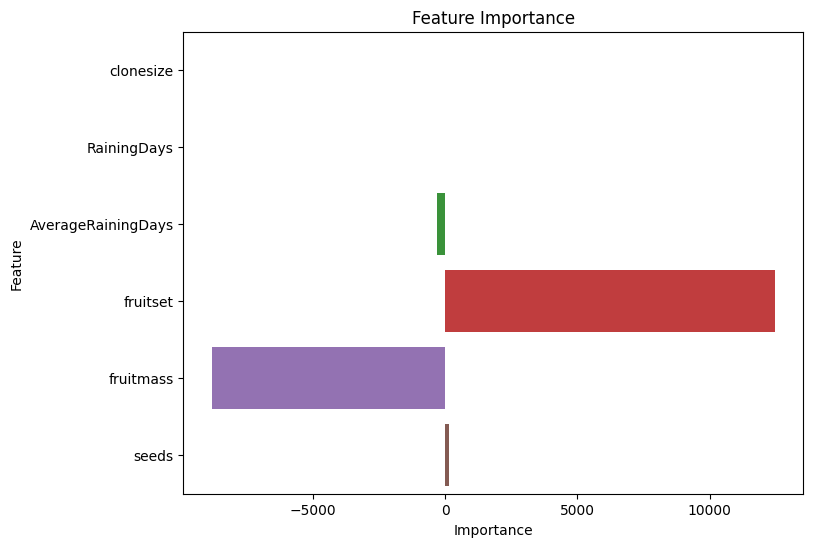

In [19]:
X = df_train[['clonesize', 'RainingDays', 'AverageRainingDays', 'fruitset', 'fruitmass', 'seeds']]
y = df_train[['yield']]

MAE_modelo, num_features  = teste_de_modelo_OLS(X, y)

lista_modelo_utilizado.append('OLS')
lista_num_features.append(num_features)
lista_MAE.append(MAE_modelo)

Média dos scores de MAE: 374.2446605684739
Desvio padrão dos scores de MAE: 5.214166037502315


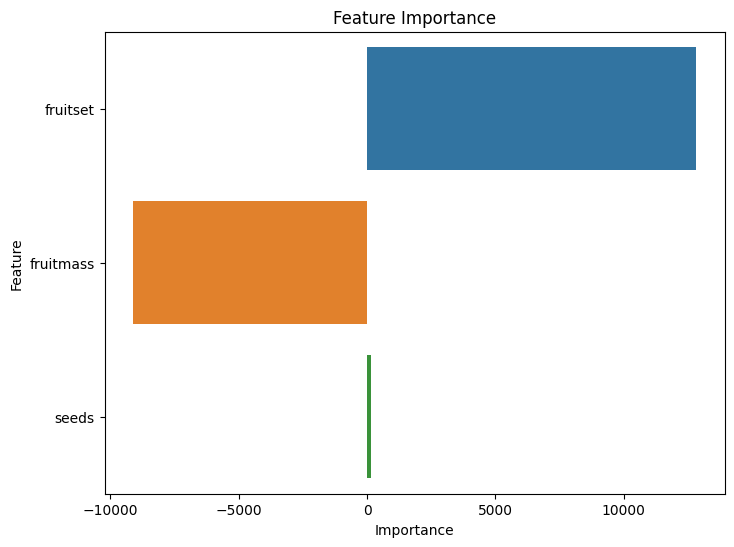

In [20]:
X = df_train[['fruitset', 'fruitmass', 'seeds']]
y = df_train[['yield']]

MAE_modelo, num_features  = teste_de_modelo_OLS(X, y)

lista_modelo_utilizado.append('OLS')
lista_num_features.append(num_features)
lista_MAE.append(MAE_modelo)

Média dos scores de MAE: 396.7983301781313
Desvio padrão dos scores de MAE: 4.906424337341919


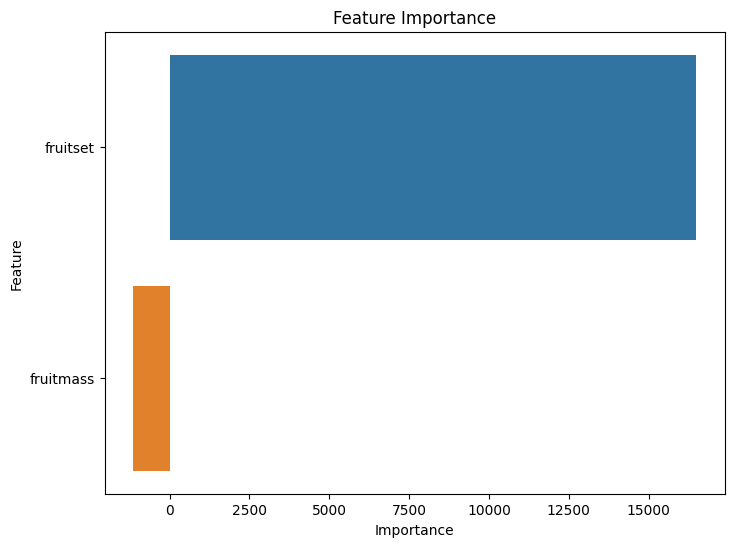

In [21]:
X = df_train[['fruitset', 'fruitmass']]
y = df_train[['yield']]

MAE_modelo, num_features  = teste_de_modelo_OLS(X, y)

lista_modelo_utilizado.append('OLS')
lista_num_features.append(num_features)
lista_MAE.append(MAE_modelo)

Média dos scores de MAE: 396.6470489064568
Desvio padrão dos scores de MAE: 4.712136021540595


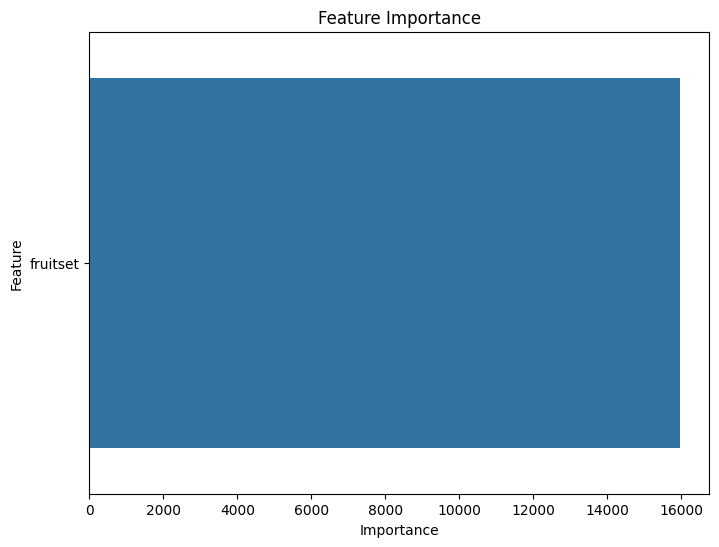

In [22]:
X = df_train[['fruitset']]
y = df_train[['yield']]

MAE_modelo, num_features  = teste_de_modelo_OLS(X, y)

lista_modelo_utilizado.append('OLS')
lista_num_features.append(num_features)
lista_MAE.append(MAE_modelo)

Ao remover variáveis, a perfomance do modelo foi reduzida. <br>
Vamos testar a utilização da Regressão de Lasso e Ridge

## Ridge Regression

In [23]:
def teste_de_modelo_RIDGE(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

    Ridge_model = Ridge(alpha=1, random_state=10)
    Ridge_model = Ridge_model.fit(X_train, y_train)
    y_pred = Ridge_model.predict(X_test).squeeze().tolist()

    plt.figure(figsize=(15,8))
    sns.scatterplot(x=y_test['yield'], y=y_pred)
    plt.title('Análise das previsões x valores reais', fontsize=15, color='blue')
    plt.xlabel('Valores Reais', fontsize=12)
    plt.ylabel('Valores previstos', fontsize=12)
    plt.show()

    MAE = mean_absolute_error(y_true=y_test, y_pred=y_pred)
    print(f'O ERRO OBTIDO PARA ESSA MODELAGEM: {MAE}')

    # Coeficientes do modelo (feature importance) e nomes das features
    feature_importance = Ridge_model.coef_[0]
    feature_names = X_train.columns  # Substitua pelos nomes reais das suas features

    # Criar um DataFrame para facilitar a plotagem
    df_importance = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

    # Plotar a importância dos recursos
    plt.figure(figsize=(8, 6))
    sns.barplot(x='Importance', y='Feature', data=df_importance, orient='h')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance')
    plt.show()

    return MAE, len(feature_names)

In [24]:
def teste_de_modelo_RIDGE_kfold(X, y, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=10)
    MAE_scores = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        Ridge_model = Ridge(alpha=1, random_state=10)
        Ridge_model = Ridge_model.fit(X_train, y_train)
        y_pred = Ridge_model.predict(X_test).squeeze().tolist()

        MAE = mean_absolute_error(y_true=y_test, y_pred=y_pred)
        MAE_scores.append(MAE)

    # Exibir a média e o desvio padrão dos scores de MAE
    print(f'Média dos scores de MAE: {np.mean(MAE_scores)}')
    print(f'Desvio padrão dos scores de MAE: {np.std(MAE_scores)}')

    # Coeficientes do modelo (feature importance) e nomes das features
    feature_importance = Ridge_model.coef_[0]
    feature_names = X.columns  # Substitua pelos nomes reais das suas features

    # Criar um DataFrame para facilitar a plotagem
    df_importance = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

    # Plotar a importância dos recursos
    plt.figure(figsize=(8, 6))
    sns.barplot(x='Importance', y='Feature', data=df_importance, orient='h')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance')
    plt.show()

    return np.mean(MAE_scores), len(feature_names)

### TODAS AS FEATURES

Média dos scores de MAE: 379.09248872742205
Desvio padrão dos scores de MAE: 14.054302138922433


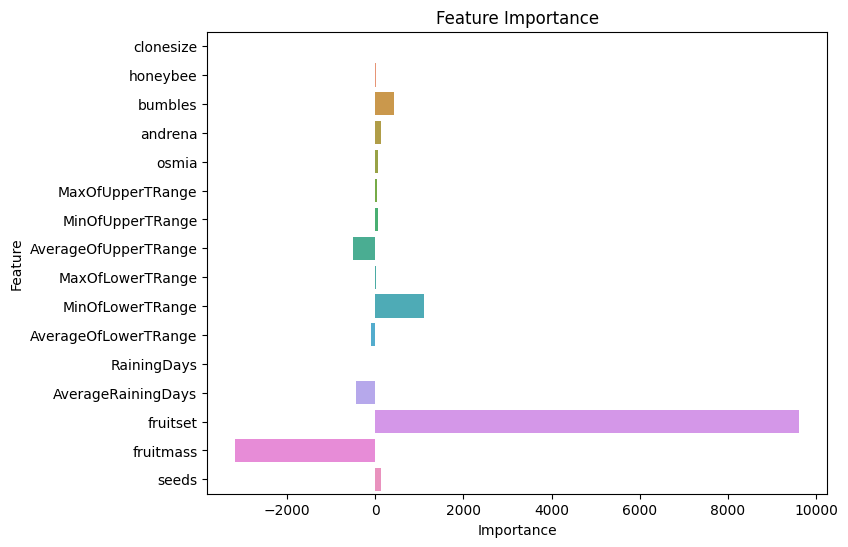

In [25]:
X = df_train.drop(columns=['id', 'yield'], axis=1)
y = df_train[['yield']]

MAE_modelo, num_features  = teste_de_modelo_RIDGE_kfold(X, y)

lista_modelo_utilizado.append('RIDGE')
lista_num_features.append(num_features)
lista_MAE.append(MAE_modelo)

O modelo utilizando Ridge regression deu peso diferentes OLS, mas o resultado foi muito próximo

### SOMENTE FEATURES CORRELACIONADAS COM A VARIÁVEL TARGET

Média dos scores de MAE: 376.0839289193949
Desvio padrão dos scores de MAE: 4.753586521449751


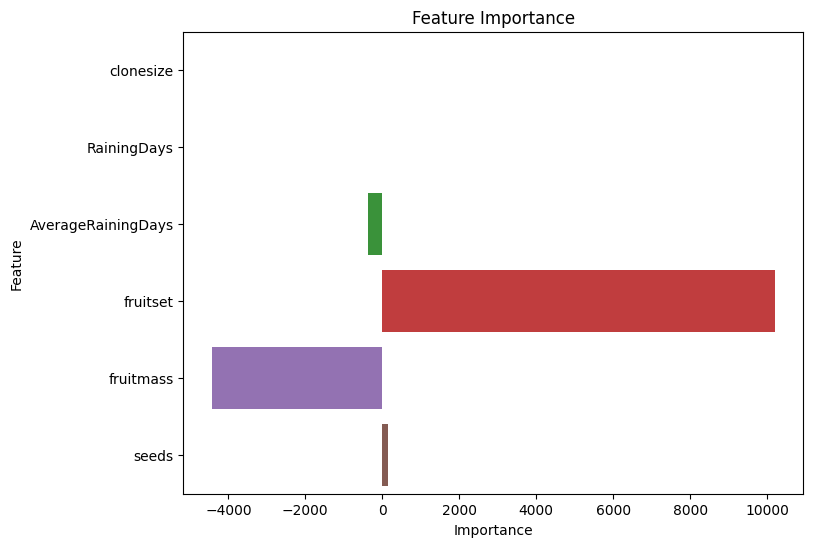

In [26]:
X = df_train[['clonesize', 'RainingDays', 'AverageRainingDays', 'fruitset', 'fruitmass', 'seeds']]
y = df_train[['yield']]

MAE_modelo, num_features  = teste_de_modelo_RIDGE_kfold(X, y)

lista_modelo_utilizado.append('RIDGE')
lista_num_features.append(num_features)
lista_MAE.append(MAE_modelo)

Média dos scores de MAE: 377.63617613991556
Desvio padrão dos scores de MAE: 4.323472020107428


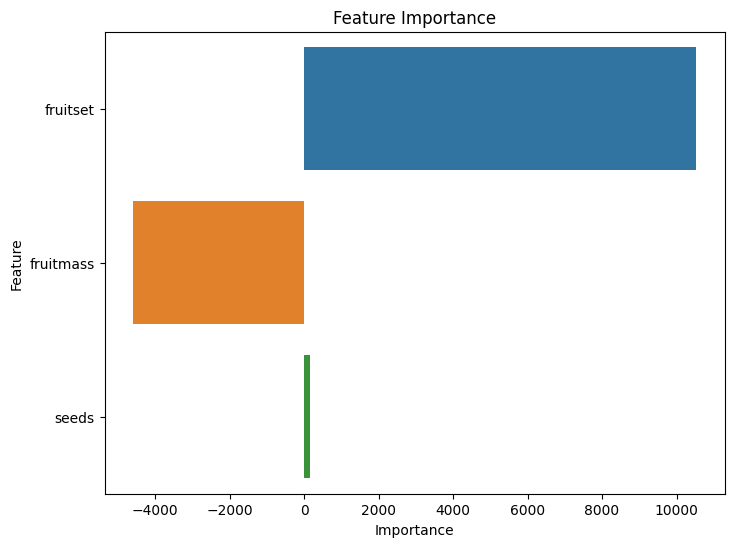

In [27]:
X = df_train[['fruitset', 'fruitmass', 'seeds']]
y = df_train[['yield']]

MAE_modelo, num_features  = teste_de_modelo_RIDGE_kfold(X, y)

lista_modelo_utilizado.append('RIDGE')
lista_num_features.append(num_features)
lista_MAE.append(MAE_modelo)

Média dos scores de MAE: 400.13485315216724
Desvio padrão dos scores de MAE: 4.315745926987656


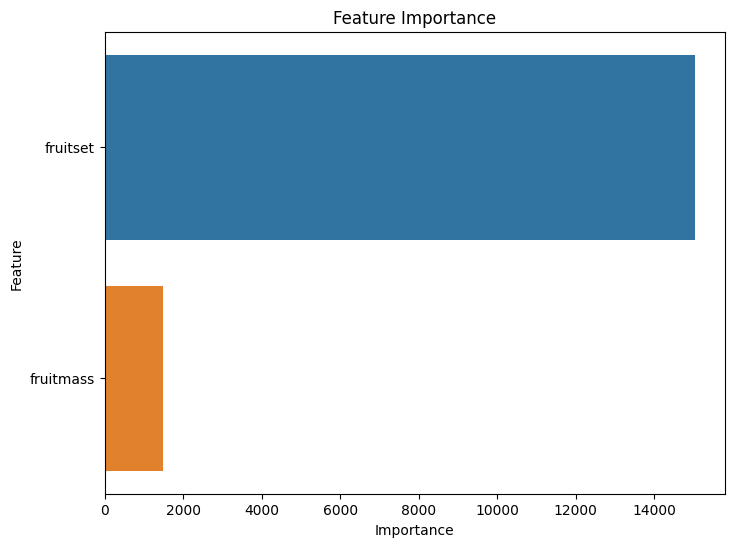

In [28]:
X = df_train[['fruitset', 'fruitmass']]
y = df_train[['yield']]

MAE_modelo, num_features  = teste_de_modelo_RIDGE_kfold(X, y)

lista_modelo_utilizado.append('RIDGE')
lista_num_features.append(num_features)
lista_MAE.append(MAE_modelo)

Média dos scores de MAE: 399.8510972417406
Desvio padrão dos scores de MAE: 4.5051201288263245


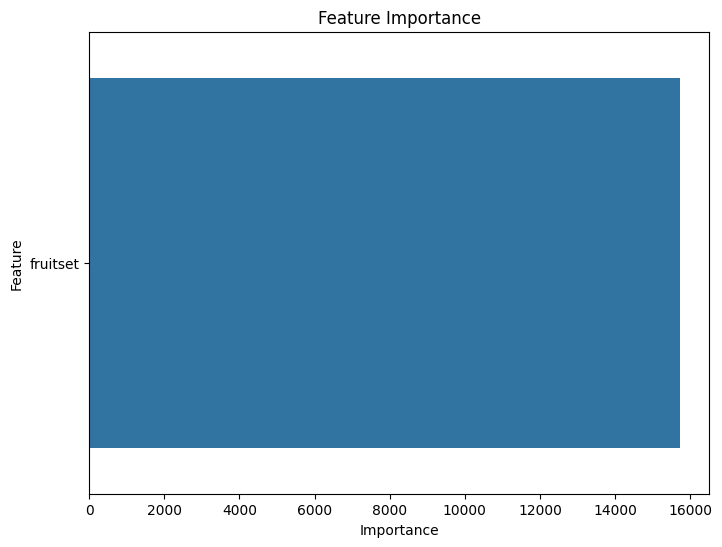

In [29]:
X = df_train[['fruitset']]
y = df_train[['yield']]

MAE_modelo, num_features  = teste_de_modelo_RIDGE_kfold(X, y)

lista_modelo_utilizado.append('RIDGE')
lista_num_features.append(num_features)
lista_MAE.append(MAE_modelo)

## Lasso Regression

In [30]:
def teste_de_modelo_LASSO_kfold(X, y, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=10)
    MAE_scores = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        Lasso_model = Lasso(alpha=1, random_state=10)
        Lasso_model = Lasso_model.fit(X_train, y_train)
        y_pred = Lasso_model.predict(X_test).squeeze().tolist()

        MAE = mean_absolute_error(y_true=y_test, y_pred=y_pred)
        MAE_scores.append(MAE)

    # Exibir a média e o desvio padrão dos scores de MAE
    print(f'Média dos scores de MAE: {np.mean(MAE_scores)}')
    print(f'Desvio padrão dos scores de MAE: {np.std(MAE_scores)}')

    # Coeficientes do modelo (feature importance) e nomes das features
    feature_importance = Lasso_model.coef_
    feature_names = X.columns  # Substitua pelos nomes reais das suas features

    # Criar um DataFrame para facilitar a plotagem
    df_importance = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

    # Plotar a importância dos recursos
    plt.figure(figsize=(8, 6))
    sns.barplot(x='Importance', y='Feature', data=df_importance, orient='h')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance')
    plt.show()

    return np.mean(MAE_scores), len(feature_names)

In [31]:
def teste_de_modelo_LASSO(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

    Lasso_model = Lasso(alpha=1, random_state=10)
    Lasso_model = Lasso_model.fit(X_train, y_train)
    y_pred = Lasso_model.predict(X_test).squeeze().tolist()

    plt.figure(figsize=(15,8))
    sns.scatterplot(x=y_test['yield'], y=y_pred)
    plt.title('Análise das previsões x valores reais', fontsize=15, color='blue')
    plt.xlabel('Valores Reais', fontsize=12)
    plt.ylabel('Valores previstos', fontsize=12)
    plt.show()

    MAE = mean_absolute_error(y_true=y_test, y_pred=y_pred)
    print(f'O ERRO OBTIDO PARA ESSA MODELAGEM: {MAE}')

    # Coeficientes do modelo (feature importance) e nomes das features
    feature_importance = Lasso_model.coef_
    feature_names = X_train.columns  # Substitua pelos nomes reais das suas features

    # Criar um DataFrame para facilitar a plotagem
    df_importance = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

    # Plotar a importância dos recursos
    plt.figure(figsize=(8, 6))
    sns.barplot(x='Importance', y='Feature', data=df_importance, orient='h')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance')
    plt.show()

    return MAE, len(feature_names)

### TODAS AS FEATURES

Média dos scores de MAE: 379.8214018559266
Desvio padrão dos scores de MAE: 4.482520669437425


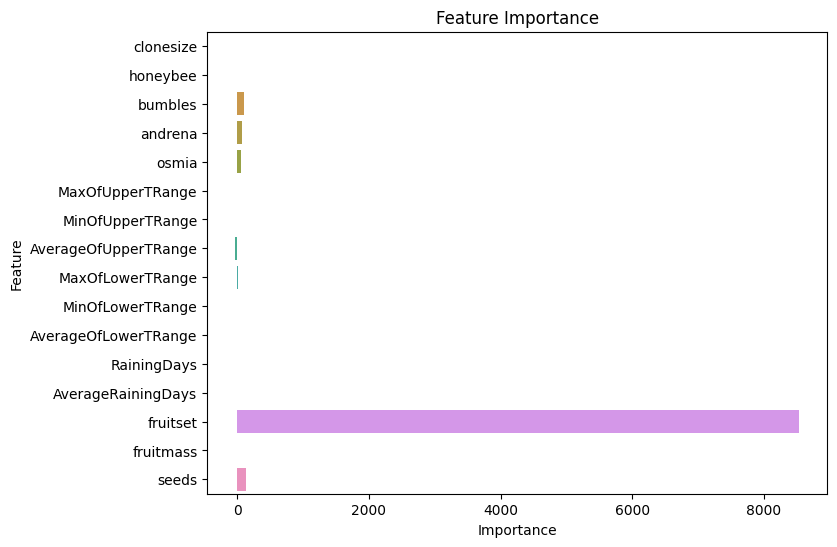

In [32]:
X = df_train.drop(columns=['id', 'yield'], axis=1)
y = df_train[['yield']]

MAE_modelo, num_features  = teste_de_modelo_LASSO_kfold(X, y)

lista_modelo_utilizado.append('LASSO')
lista_num_features.append(num_features)
lista_MAE.append(MAE_modelo)

### SOMENTE AS FEATURES CORRELACIONADAS COM A VARIÁVEL TARGET

Média dos scores de MAE: 383.0141873344601
Desvio padrão dos scores de MAE: 4.189304258991864


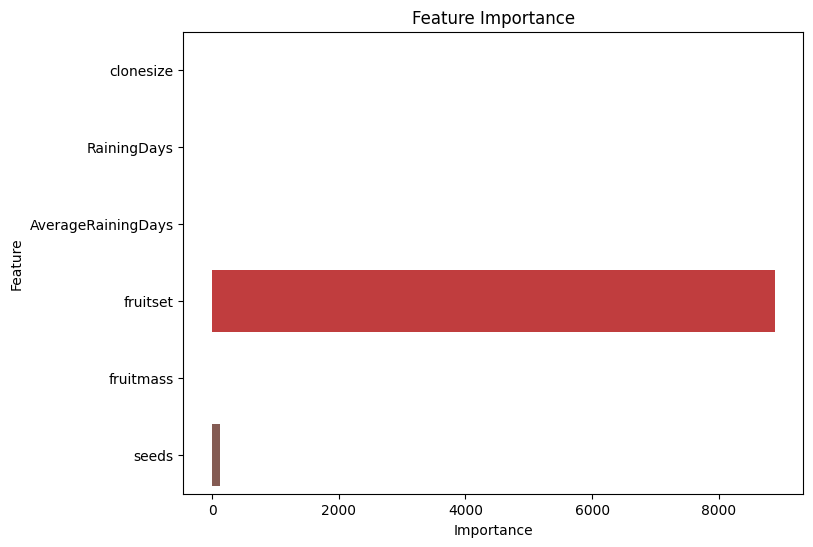

In [33]:
X = df_train[['clonesize', 'RainingDays', 'AverageRainingDays', 'fruitset', 'fruitmass', 'seeds']]
y = df_train[['yield']]

MAE_modelo, num_features  = teste_de_modelo_LASSO_kfold(X, y)

lista_modelo_utilizado.append('LASSO')
lista_num_features.append(num_features)
lista_MAE.append(MAE_modelo)

Média dos scores de MAE: 384.40708208578474
Desvio padrão dos scores de MAE: 4.113182101168175


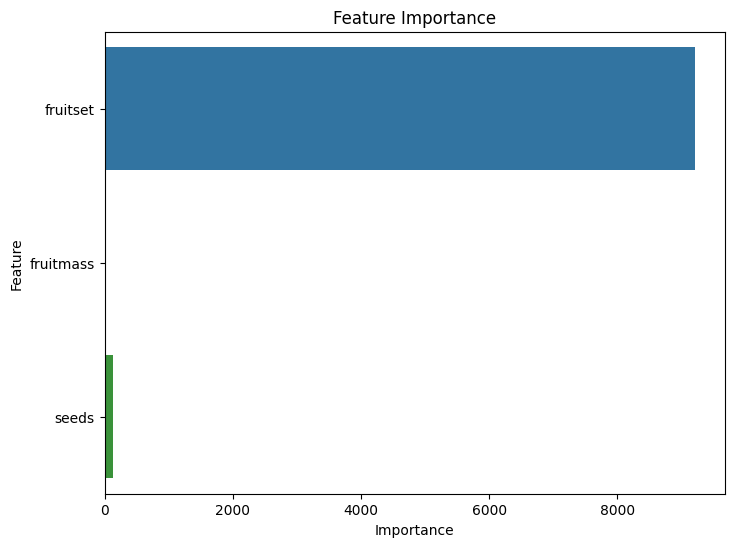

In [34]:
X = df_train[['fruitset', 'fruitmass', 'seeds']]
y = df_train[['yield']]

MAE_modelo, num_features  = teste_de_modelo_LASSO_kfold(X, y)

lista_modelo_utilizado.append('LASSO')
lista_num_features.append(num_features)
lista_MAE.append(MAE_modelo)

Média dos scores de MAE: 399.0749901809033
Desvio padrão dos scores de MAE: 4.549928869456955


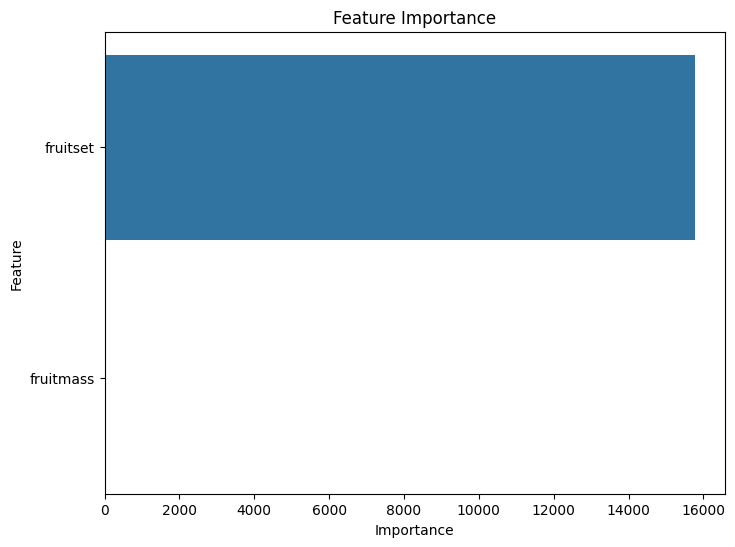

In [35]:
X = df_train[['fruitset', 'fruitmass']]
y = df_train[['yield']]

MAE_modelo, num_features  = teste_de_modelo_LASSO_kfold(X, y)

lista_modelo_utilizado.append('LASSO')
lista_num_features.append(num_features)
lista_MAE.append(MAE_modelo)

Média dos scores de MAE: 399.0749901809033
Desvio padrão dos scores de MAE: 4.549928869456955


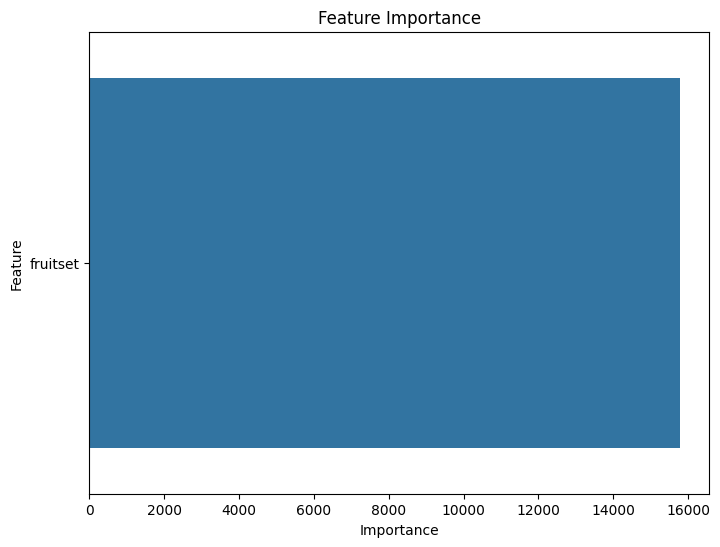

In [36]:
X = df_train[['fruitset']]
y = df_train[['yield']]

MAE_modelo, num_features  = teste_de_modelo_LASSO_kfold(X, y)

lista_modelo_utilizado.append('LASSO')
lista_num_features.append(num_features)
lista_MAE.append(MAE_modelo)

## LGBM Regressor

In [37]:
def teste_de_modelo_LGBM(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

    lgbm_model = LGBMRegressor(random_state=10)
    lgbm_model.fit(X_train, y_train)
    y_pred = lgbm_model.predict(X_test)

    plt.figure(figsize=(15,8))
    sns.scatterplot(x=y_test['yield'], y=y_pred)
    plt.title('Análise das previsões x valores reais', fontsize=15, color='blue')
    plt.xlabel('Valores Reais', fontsize=12)
    plt.ylabel('Valores previstos', fontsize=12)
    plt.show()

    MAE = mean_absolute_error(y_true=y_test, y_pred=y_pred)
    print(f'O ERRO OBTIDO PARA ESSA MODELAGEM: {MAE}')

    # Feature importance do modelo
    feature_importance = lgbm_model.feature_importances_
    feature_names = X_train.columns

    # Criar DataFrame para plotar a importância dos recursos
    df_importance = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

    # Plotar a importância dos recursos
    plt.figure(figsize=(8, 6))
    sns.barplot(x='Importance', y='Feature', data=df_importance.sort_values(by='Importance', ascending=False), orient='h')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance')
    plt.show()

    return MAE, len(feature_names)

In [38]:
def teste_de_modelo_LGBM_kfold(X, y, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=10)
    MAE_scores = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        lgbm_model = LGBMRegressor(random_state=10)
        lgbm_model.fit(X_train, y_train)
        y_pred = lgbm_model.predict(X_test)

        MAE = mean_absolute_error(y_true=y_test, y_pred=y_pred)
        MAE_scores.append(MAE)

    # Exibir a média e o desvio padrão dos scores de MAE
    print(f'Média dos scores de MAE: {np.mean(MAE_scores)}')
    print(f'Desvio padrão dos scores de MAE: {np.std(MAE_scores)}')

    # Feature importance do modelo
    feature_importance = lgbm_model.feature_importances_
    feature_names = X.columns

    # Criar DataFrame para plotar a importância dos recursos
    df_importance = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

    # Plotar a importância dos recursos
    plt.figure(figsize=(8, 6))
    sns.barplot(x='Importance', y='Feature', data=df_importance.sort_values(by='Importance', ascending=False), orient='h')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance')
    plt.show()

    return np.mean(MAE_scores), len(feature_names)

### TODAS AS FEATURES

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000293 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 848
[LightGBM] [Info] Number of data points in the train set: 12231, number of used features: 16
[LightGBM] [Info] Start training from score 6021.389860
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000291 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 847
[LightGBM] [Info] Number of data points in the train set: 12231, number of used features: 16
[LightGBM] [Info] Start training from score 6026.077178
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000275 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

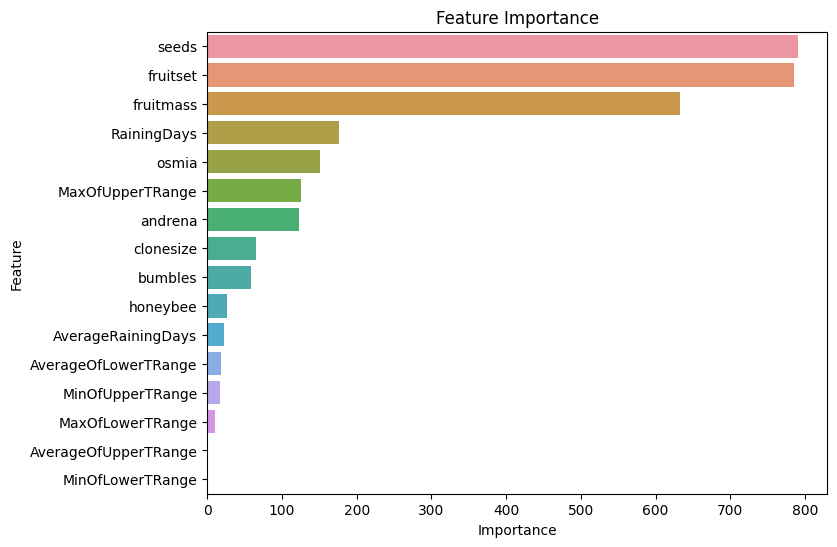

In [39]:
X = df_train.drop(columns=['id', 'yield'], axis=1)
y = df_train[['yield']]

MAE_modelo, num_features  = teste_de_modelo_LGBM_kfold(X, y)

lista_modelo_utilizado.append('LGBM REGRESSOR')
lista_num_features.append(num_features)
lista_MAE.append(MAE_modelo)

### SOMENTE FEATURES CORRELACIONADAS COM VARIÁVEL TARGET

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 784
[LightGBM] [Info] Number of data points in the train set: 12231, number of used features: 6
[LightGBM] [Info] Start training from score 6021.389860
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 784
[LightGBM] [Info] Number of data points in the train set: 12231, number of used features: 6
[LightGBM] [Info] Start training from score 6026.077178
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000341 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 783
[LightGBM] [Info] Number of data points in the train set: 12231, number of used features: 6
[LightGBM] [Info] Start tra

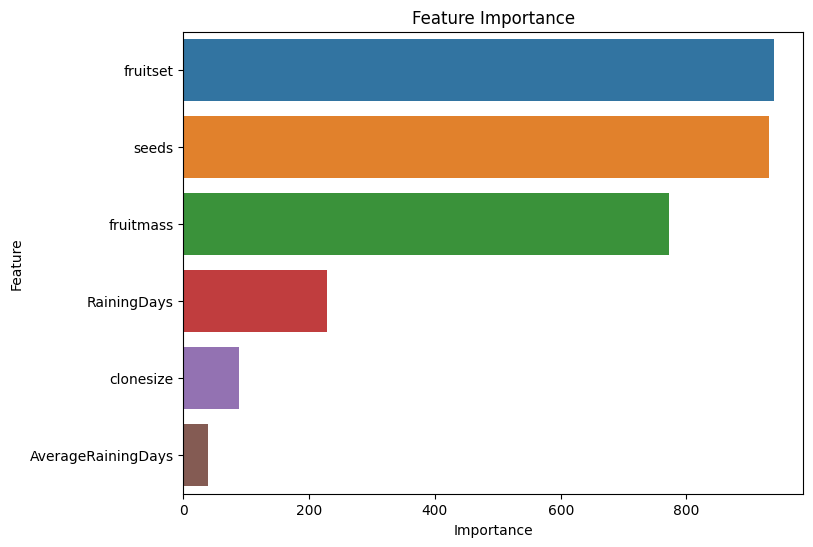

In [40]:
X = df_train[['clonesize', 'RainingDays', 'AverageRainingDays', 'fruitset', 'fruitmass', 'seeds']]
y = df_train[['yield']]
MAE_modelo, num_features  = teste_de_modelo_LGBM_kfold(X, y)

lista_modelo_utilizado.append('LGBM REGRESSOR')
lista_num_features.append(num_features)
lista_MAE.append(MAE_modelo)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 12231, number of used features: 3
[LightGBM] [Info] Start training from score 6021.389860
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 12231, number of used features: 3
[LightGBM] [Info] Start training from score 6026.077178
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 764
[LightGBM] [Info] Number of data points in the train set: 12231, number of used features: 3
[LightGBM] [Info] Start tra

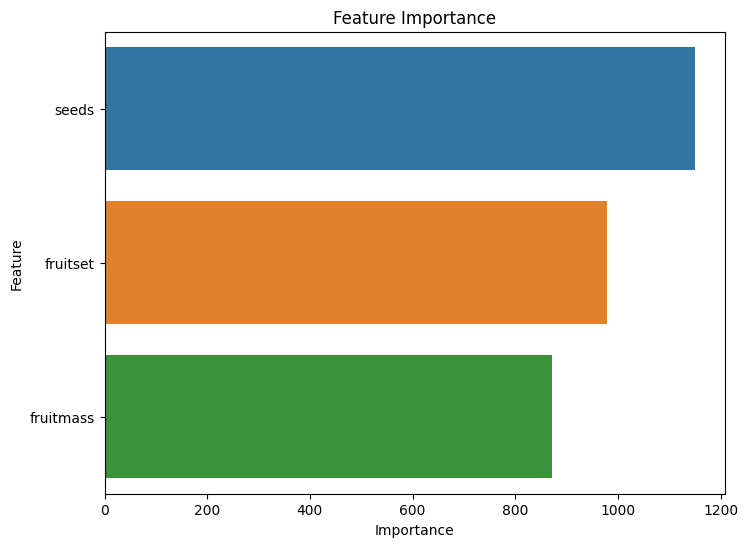

In [41]:
X = df_train[['fruitset', 'fruitmass', 'seeds']]
y = df_train[['yield']]
MAE_modelo, num_features  = teste_de_modelo_LGBM_kfold(X, y)

lista_modelo_utilizado.append('LGBM REGRESSOR')
lista_num_features.append(num_features)
lista_MAE.append(MAE_modelo)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 12231, number of used features: 2
[LightGBM] [Info] Start training from score 6021.389860
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 12231, number of used features: 2
[LightGBM] [Info] Start training from score 6026.077178
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 509
[LightGBM] [Info] Number of data points in the train set: 12231, number of used features: 2
[LightGBM] [Info] Start tra

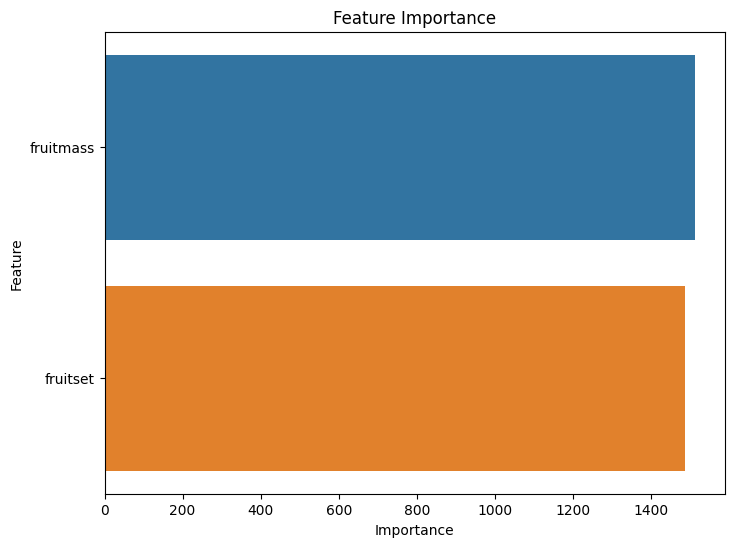

In [42]:
X = df_train[['fruitset', 'fruitmass']]
y = df_train[['yield']]
MAE_modelo, num_features  = teste_de_modelo_LGBM_kfold(X, y)

lista_modelo_utilizado.append('LGBM REGRESSOR')
lista_num_features.append(num_features)
lista_MAE.append(MAE_modelo)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000035 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 12231, number of used features: 1
[LightGBM] [Info] Start training from score 6021.389860
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000040 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 12231, number of used features: 1
[LightGBM] [Info] Start training from score 6026.077178
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total 

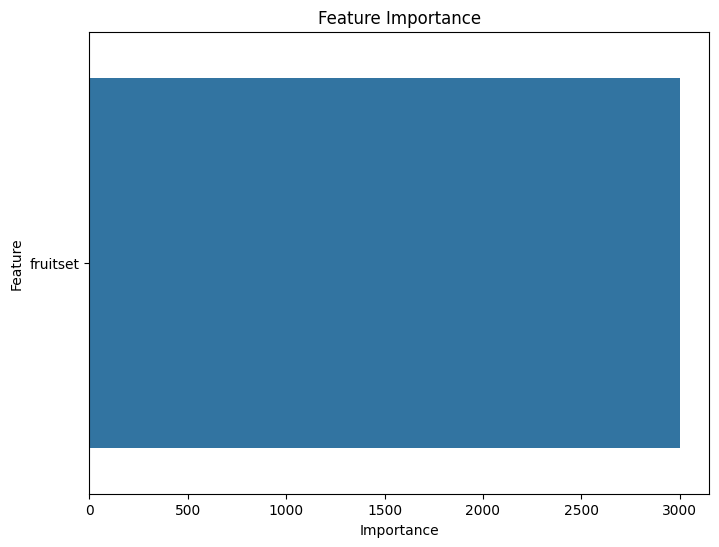

In [43]:
X = df_train[['fruitset']]
y = df_train[['yield']]
MAE_modelo, num_features  = teste_de_modelo_LGBM_kfold(X, y)

lista_modelo_utilizado.append('LGBM REGRESSOR')
lista_num_features.append(num_features)
lista_MAE.append(MAE_modelo)

## XGB Regressor

In [44]:
def teste_de_modelo_XGB(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

    lgbm_model = XGBRegressor(random_state=10)
    lgbm_model.fit(X_train, y_train)
    y_pred = lgbm_model.predict(X_test)

    plt.figure(figsize=(15,8))
    sns.scatterplot(x=y_test['yield'], y=y_pred)
    plt.title('Análise das previsões x valores reais', fontsize=15, color='blue')
    plt.xlabel('Valores Reais', fontsize=12)
    plt.ylabel('Valores previstos', fontsize=12)
    plt.show()

    MAE = mean_absolute_error(y_true=y_test, y_pred=y_pred)
    print(f'O ERRO OBTIDO PARA ESSA MODELAGEM: {MAE}')

    # Feature importance do modelo
    feature_importance = lgbm_model.feature_importances_
    feature_names = X_train.columns

    # Criar DataFrame para plotar a importância dos recursos
    df_importance = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

    # Plotar a importância dos recursos
    plt.figure(figsize=(8, 6))
    sns.barplot(x='Importance', y='Feature', data=df_importance.sort_values(by='Importance', ascending=False), orient='h')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance')
    plt.show()

    return MAE, len(feature_names)

In [45]:
def teste_de_modelo_XGB_kfold(X, y, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=10)
    MAE_scores = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        xgb_model = XGBRegressor(random_state=10)
        xgb_model.fit(X_train, y_train)
        y_pred = xgb_model.predict(X_test)

        MAE = mean_absolute_error(y_true=y_test, y_pred=y_pred)
        MAE_scores.append(MAE)

    # Exibir a média e o desvio padrão dos scores de MAE
    print(f'Média dos scores de MAE: {np.mean(MAE_scores)}')
    print(f'Desvio padrão dos scores de MAE: {np.std(MAE_scores)}')

    # Feature importance do modelo
    feature_importance = xgb_model.feature_importances_
    feature_names = X.columns

    # Criar DataFrame para plotar a importância dos recursos
    df_importance = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

    # Plotar a importância dos recursos
    plt.figure(figsize=(8, 6))
    sns.barplot(x='Importance', y='Feature', data=df_importance.sort_values(by='Importance', ascending=False), orient='h')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance')
    plt.show()

    return np.mean(MAE_scores), len(feature_names)

### TODAS AS FEATURES

Média dos scores de MAE: 374.8848101979437
Desvio padrão dos scores de MAE: 4.511797597257187


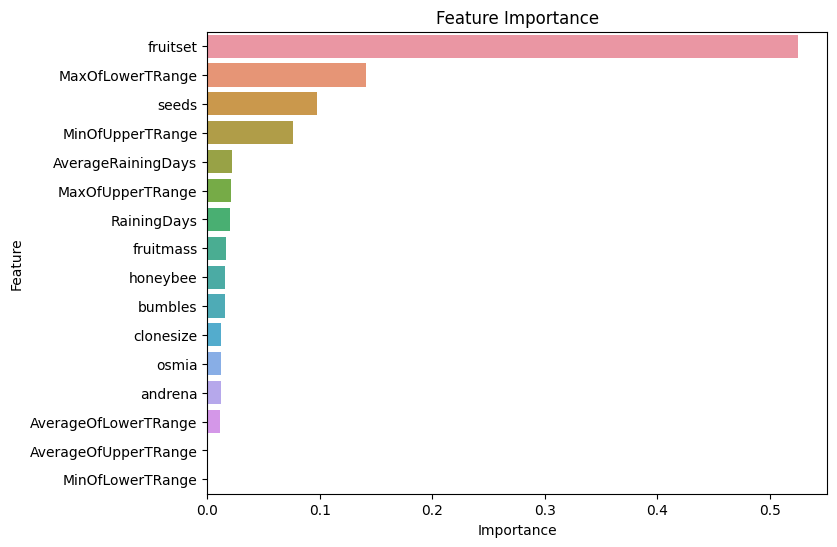

In [46]:
X = df_train.drop(columns=['id', 'yield'], axis=1)
y = df_train[['yield']]

MAE_modelo, num_features  = teste_de_modelo_XGB_kfold(X, y)

lista_modelo_utilizado.append('XGB REGRESSOR')
lista_num_features.append(num_features)
lista_MAE.append(MAE_modelo)

### SOMENTE FEATURES CORRELACIONADAS COM VARIÁVEL TARGET

Média dos scores de MAE: 374.7628716020472
Desvio padrão dos scores de MAE: 3.5803715741820072


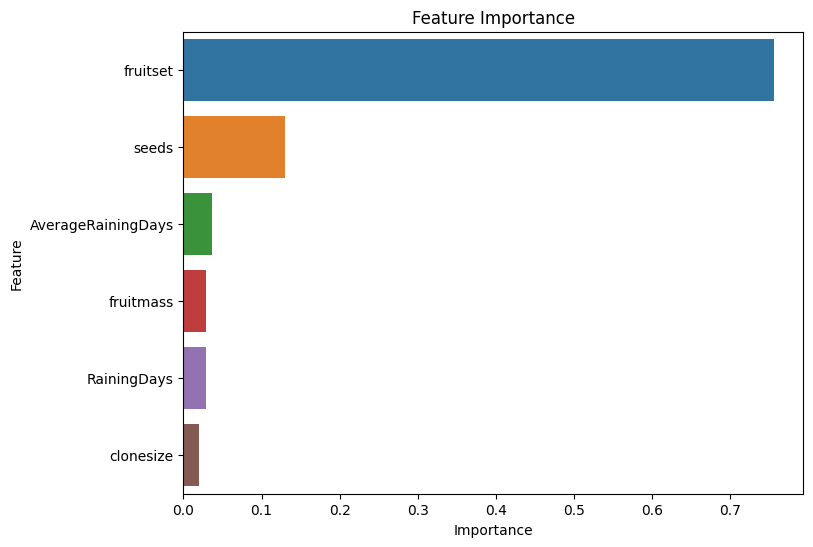

In [47]:
X = df_train[['clonesize', 'RainingDays', 'AverageRainingDays', 'fruitset', 'fruitmass', 'seeds']]
y = df_train[['yield']]
MAE_modelo, num_features  = teste_de_modelo_XGB_kfold(X, y)

lista_modelo_utilizado.append('XGB REGRESSOR')
lista_num_features.append(num_features)
lista_MAE.append(MAE_modelo)

Média dos scores de MAE: 373.4051839026706
Desvio padrão dos scores de MAE: 4.925591623891184


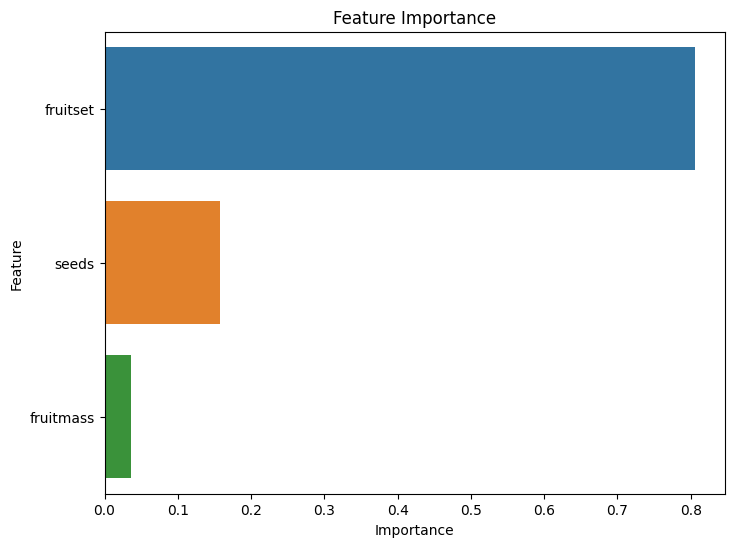

In [48]:
X = df_train[['fruitset', 'fruitmass', 'seeds']]
y = df_train[['yield']]
MAE_modelo, num_features  = teste_de_modelo_XGB_kfold(X, y)

lista_modelo_utilizado.append('XGB REGRESSOR')
lista_num_features.append(num_features)
lista_MAE.append(MAE_modelo)

Média dos scores de MAE: 397.48616769115864
Desvio padrão dos scores de MAE: 5.388854286744948


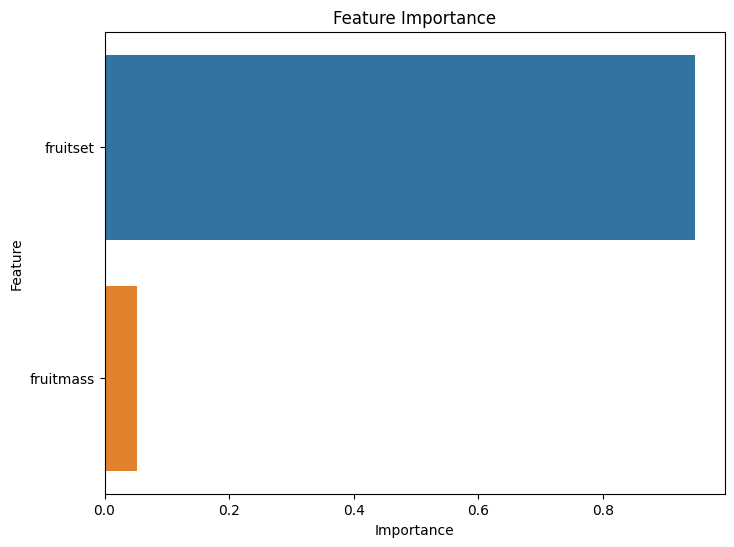

In [49]:
X = df_train[['fruitset', 'fruitmass']]
y = df_train[['yield']]
MAE_modelo, num_features  = teste_de_modelo_XGB_kfold(X, y)

lista_modelo_utilizado.append('XGB REGRESSOR')
lista_num_features.append(num_features)
lista_MAE.append(MAE_modelo)

Média dos scores de MAE: 391.1173112026753
Desvio padrão dos scores de MAE: 6.875146316354824


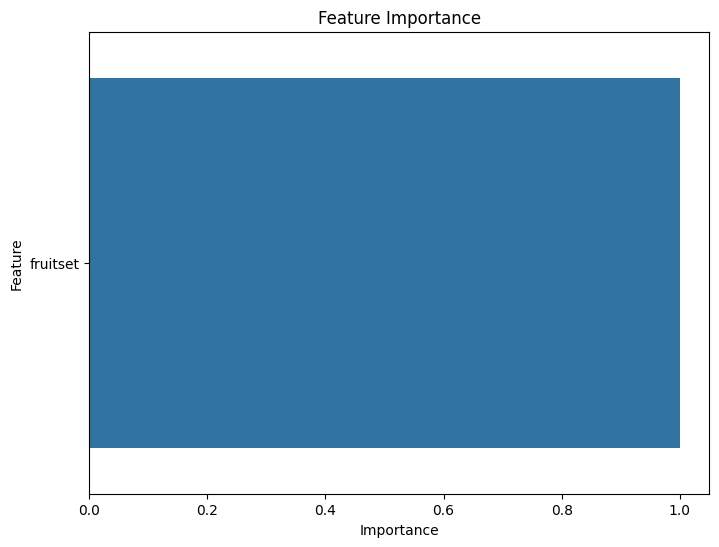

In [50]:
X = df_train[['fruitset']]
y = df_train[['yield']]
MAE_modelo, num_features  = teste_de_modelo_XGB_kfold(X, y)

lista_modelo_utilizado.append('XGB REGRESSOR')
lista_num_features.append(num_features)
lista_MAE.append(MAE_modelo)

# Resultados

In [51]:
resultados_modelos = pd.DataFrame({'MODELO':lista_modelo_utilizado,
             'NUM_FEATURES':lista_num_features,
             'MAE':lista_MAE})

resultados_modelos.sort_values(by='MAE')

,MODELO,NUM_FEATURES,MAE
15,LGBM REGRESSOR,16,355.902633
16,LGBM REGRESSOR,6,357.014904
17,LGBM REGRESSOR,3,358.315510
1,OLS,6,372.570830
22,XGB REGRESSOR,3,373.405184
2,OLS,3,374.244661
21,XGB REGRESSOR,6,374.762872
20,XGB REGRESSOR,16,374.884810
6,RIDGE,6,376.083929
0,OLS,16,376.173783
